# Einfache Vorhersagemethoden

* Lineare Regression
* (dreifache) Exponentielle Glättung

## 1. Lineare Regression

In [1]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import scipy.stats


/home/rp/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
matplotlib.__version__

'3.8.2'

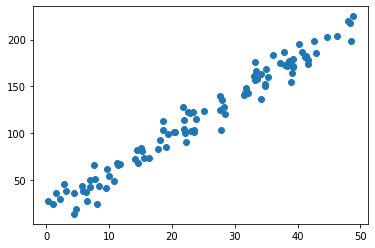

In [3]:
# Create demo data

ndat = 100
rng = np.random.default_rng(42)
rng2 = np.random.default_rng(43)


def my_lin(x, m=4, b=20, e=0):
    return m * x + b + e
    
x = rng.random(ndat)*50
e = rng2.normal(0,10,len(x))
y = my_lin(x, e=e)


plt.scatter(x,y)
plt.show()

In [4]:
# linear regression demo

a = scipy.stats.linregress(x,y)

print(f'y = {a.slope:.2g}x + {a.intercept:.3g}')

y = 4.1x + 16.8


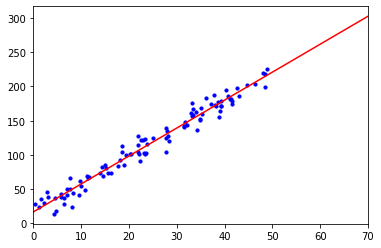

In [5]:
plt.scatter(x,y, color='blue', s=10)

extrapol=70
line_points = [0,extrapol]
plt.plot(line_points, my_lin(np.array(line_points), m=a.slope, b=a.intercept),
        color='red')
plt.xlim(0,extrapol)
plt.show()


## Beispiel Temperaturvorhersage

Quelle: https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities

In [6]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# https://www.kaggle.com/datasets/sudalairajkumar/daily-temperature-of-major-cities
fn = 'data/city_temperature.zip'

df = pd.read_csv(fn, compression='zip', low_memory=False) 
                    
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906327 entries, 0 to 2906326
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Region          object 
 1   Country         object 
 2   State           object 
 3   City            object 
 4   Month           int64  
 5   Day             int64  
 6   Year            int64  
 7   AvgTemperature  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 767.7 MB


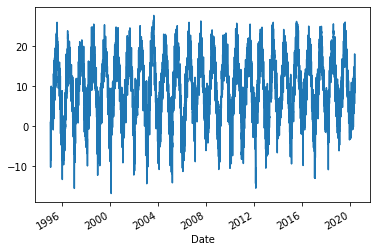

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9850 entries, 1995-01-01 to 2020-05-13
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   AvgTemperature  9850 non-null   float64
dtypes: float64(1)
memory usage: 153.9 KB
None


,AvgTemperature
Date,
1995-01-01,0.944444
1995-01-02,-1.611111
1995-01-03,-3.555556
1995-01-04,-9.833333
1995-01-05,-10.222222


In [7]:
df = df[df['City']=='Munich']
df = df[['Year', 'Month', 'Day', 'AvgTemperature']]


df = df[df['AvgTemperature']>-70]

df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']]) 
df = df.set_index(df['Date'])
df = df[['AvgTemperature']]

df['AvgTemperature'] = (df['AvgTemperature']-32)*5/9

df['AvgTemperature'].plot()
plt.show()

print(df.info(memory_usage="deep"))
df.head()

In [8]:
dg = df.copy()

resamp = 'D'
dg = dg.resample(resamp).mean()
print('Missing: ', resamp, ': ', dg.loc[:, :].isnull().sum() )

resamp = '2W'
dg = dg.resample(resamp).mean()
print('Missing: ', resamp, ': ', dg.loc[:, :].isnull().sum() )

Missing:  D :  AvgTemperature    72
dtype: int64
Missing:  2W :  AvgTemperature    1
dtype: int64


In [9]:
dg = dg.interpolate(method='linear')
print('Missing: ', resamp, ': ', dg.loc[:, :].isnull().sum() )

Missing:  2W :  AvgTemperature    0
dtype: int64


<Axes: xlabel='Date'>

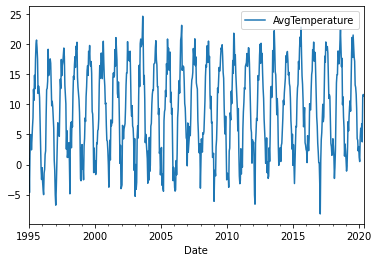

In [10]:
dg.plot()

## Holt-Winters Exponentielle Glättung

Zur Erinnerung:

### Einfache exponentielle Glättung:

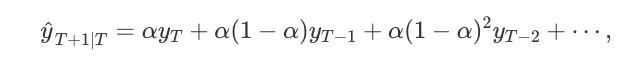


---

Genauer:
    
Seien $x_t$ die Messwerte, und $s_t$ die berechneten Glättungen zu den Zeitpunkten $t$.

(0) $s_0 = x_0$

(1) $s_t = \alpha \cdot x_t + (1-\alpha) \cdot s_{t-1}$

Andere Schreibweise für (1) mit  $e = x_t - s_{t-1}$ und $e$ als Abweichung zwischen Messwert und geglättetem Wert (beachte die etwas unglückliche Indizierung: die Indices der geglätteten Werte sind denen der Messwerte um $1$ voraus):

(1b) $s_t = s_{t-1} + \alpha \cdot e$

Der geglättete Wert $s_t$ führt zur Vorhersage $F_{t+1}$:

(2) $F_{t+1} = s_t$

Aus (1) und (2) folgt:  

(3) $F_{t+1} = \alpha \cdot x_t + (1-\alpha) \cdot s_{t-1}$

aus (3) und (1) folgt:

(4)  $F_{t+1} = \alpha \cdot x_t + (1-\alpha) \cdot \left (\alpha x_{t-1} + (1-\alpha) \cdot s_{t-2} \right ) = \alpha \cdot x_t + (1-\alpha) \cdot \alpha x_{t-1} + (1-\alpha)^2 \cdot s_{t-2}$

aus (4) und (1) folgt ... bis die Rekursion bei (0) endet.

Basierend auf (2) lassen sich auch viele Schritte (*multi step*) in die Zukunft ableiten:

(2b) $F_(t+k) = s_t$ mit mit k=1, 2, 3...

Da eine einfache exponentielle Glättung keinen Trend erkennt, verharrt die Vorhersage auf einem konstanten Level, genauer dem Startwert (den es nicht geben dürfte, da die Exponentialfunktion keinen Anfang hat).

---

### Zweifache exponentielle Glättung (Holt Methode)

Holt (1957) erweiterte die einfache exponentielle Glättung, um zumindest den Trend zu erkennen.
von 1957. Die Methode von Holt umfasst eine Vorhersagegleichung, die zwei Glättungsgleichungen zusammenführt (eine für das **Niveau** und eine für den **Trend**):

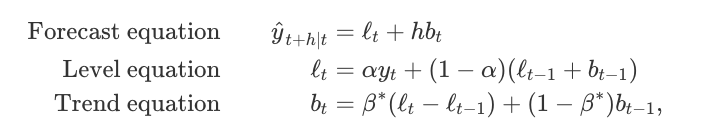

mit 

* 0\<= alpha \<=1 Level-Glättungsparameter,
* 0\<= beta \<=1 Trend-Glättungsparameter

Bei den langfristigen Prognosen wird die Vorhersage instabil. Manchmal hilft ein Dämpfungsparameter von 0< Phi <1, um die Vorhersage zu beschränken.

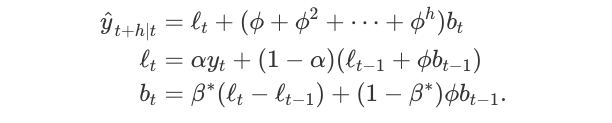

---

Genauer:

Oben wurde angenommen:

(1) $S_t = \alpha \cdot x_t + (1-\alpha) \cdot S_{t-1}$

Jetzt ersetzen wir $S_t$ durch einen Ausdruck, der sowohl den Level $S$, als auch den Trend $T$ enthält:

(6) $S_t = \alpha \cdot x_t + (1-\alpha)(S_{t-1} + T_{t-1})$

mit den Startwerten:

(6a) $S_0 = x_0$ und $T_0 = x_1 - x_0$

Der Trend drückt sich aus durch die Differenz zweier aufeinanderfolgender Schätzungen $S_t - S{t-1}$:

(7) $T_t = \beta(S_t - S{t-1}) + (1-\beta) \cdot T{t-1}$

Die Vorhersage entsprechend (2):

(8) $F{t+1} = S_t + T_t$

*Level* und *Trend* können sich additiv wie in (8) verhalten; Beispiel: der Schuhverkauf steigt jedes Jahr um 10 Einheiten. 

Oder auch multiplikativ wie in (8b); Beispiel: der Schuverkauf steigt jedes Jahr um 10%.

(8b) $F{t+1} = S_t * T_t$

Die Vorhersage von $k$ Zeitschritten (additiv):

(9)  $F{t+k} = S_t + k\cdot T_t$ mit k=1, 2, 3...

---

### Dreifache exponentielle Glättung (Holt-Winters Methode)

Die Methode berücksichtigt -- neben Level und Trend -- auch *eine* Periodizität *L*. Ähnlich wie beim Verfahren oben werden vorangegangene Werte gewichtet, bei der Periodizität genau die entsprechenden Werte vorangegangener Perioden. Der Dämpfungsfaktur ist $\gamma$.


$$
s_0 = y_0\\
s_t = \alpha (y_t-c_{t-L}) + (1-\alpha)(s_{t-1} + b_{t-1})\\
b_t = \beta (s_t - s_{t-1}) + (1-\beta)b_{t-1}\\
c_t = \gamma (y_t-s_{t-1}-b_{t-1})+(1-\gamma)c_{t-L}\\
F_{t+h} = s_t + hb_t+c_{t-L+1+(h-1) \bmod L},
$$

* y: beobachtet
* s: geglättet  
* $\alpha, \beta, \gamma$: Glättungsparameter
* L: Saisonalitätsperiode
* h: Zeitschritte für die Vorhersage
* F: Vorhersagewerte
* ausgespart
    * $\Phi$: Dämpfungsfaktor
    * Unterscheidung zwischen multiplikativer und additiver Methode.


---

Etwas genauer:

In Analogie zu (6) kommt jetzt ein Ausdruck für die Saisonalität hinzu:

(10) $S_t = \alpha \frac{x_t}{C_{t-L}} + (1-\alpha)(S_{t-1} + \Phi \cdot T_{t-1})$

mit 

(7) $T_t = \beta(S_t - S{t-1}) + (1-\beta) \cdot  \Phi \cdot T{t-1}$

und

(11) $C_t = \gamma (\frac{x_t}{S_t} + (1-\gamma)\cdot C_{t-L}$

Die Vorhersage der nächsten k Schritte:

(12) $F_{t+k}  = (S_t + kT_t)C_{(t+1)-L+(k-1)\bmod L}$

mit 
* $k$: Zahl der Vorhersageschritte 
* $L$: Zahl der Schritte, die eine Periode umfassen
* $\Phi$: Dämpfungsfaktor (falls erforderlich, sonst $=1$)

Wie bei der zweifachen exponentiellen Glättung kann der saisonale Teil additiv (wie hier) oder multiplikativ hinzugefügt werden. Weiterhin kann ein Dämpfungsfaktor $\Psi$ hinzugefügt werden, der langfristige Vorhersagen korrigiert. 

## Demo: dreifache exponentielle Glättung

### Vorbereiten der dreifachen exponentiellen Glättung

Daten: jährliche Temperaturschwankungen, gemittelt über zwei Wochen. Dann beträgt die Jahresperiode 26 Doppelwochen.

<Axes: xlabel='Date'>

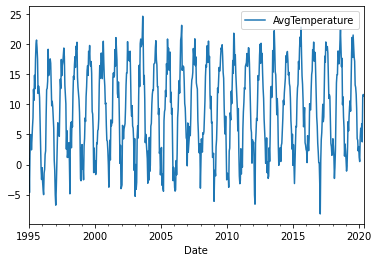

In [11]:
dg.plot()

In [12]:
dh = dg.copy()

from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0.00001,1))
dh['scal'] = sc.fit_transform(dh)

model = ExponentialSmoothing(dh['scal'], trend='add',  seasonal='add', use_boxcox=False,
                           seasonal_periods=26)
dh.head()

,AvgTemperature,scal
Date,,
1995-01-01,0.944444,0.278617
1995-01-15,-4.678571,0.107566
1995-01-29,1.591270,0.298293
1995-02-12,4.234127,0.378688
1995-02-26,4.984127,0.401503


#### Vorgabe der Parameter alpha, beta und gamma

Parameter geraten, ohne Bezug zu den realen Daten.

In [13]:
dmodel = model.fit(
    smoothing_level = 0.1,
    smoothing_trend = 0.5,
    smoothing_seasonal = 0.1,
    optimized=False
    )

dhfc = pd.DataFrame(dmodel.forecast(3*26), columns=['forecast'])
dhfc['forecast'] = sc.inverse_transform([dhfc.loc[:,'forecast'].tolist()])[0,:]
dh['fitted'] = sc.inverse_transform([dmodel.fittedvalues.tolist()])[0,:]

hw_param = f"({dmodel.params['smoothing_level']:.2g}, \
{dmodel.params['smoothing_trend']:.2g}, {dmodel.params['smoothing_seasonal']:.2g})"

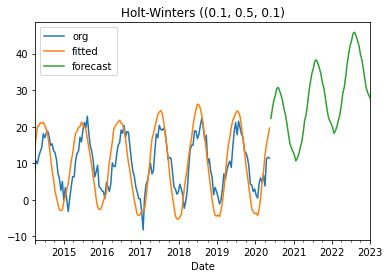

None
---
{'smoothing_level': 0.1, 'smoothing_trend': 0.5, 'smoothing_seasonal': 0.1, 'damping_trend': nan, 'initial_level': 0.5248976555268727, 'initial_trend': -0.004727013854325279, 'initial_seasons': array([-0.26926465, -0.27734464, -0.32197579, -0.33557927, -0.20622555,
       -0.13339995, -0.14630874, -0.08052457, -0.05852629,  0.08138289,
        0.15507437,  0.16887168,  0.26996105,  0.23763939,  0.2601973 ,
        0.30446072,  0.30709146,  0.30655289,  0.18205556,  0.11545019,
        0.09699322,  0.05997541, -0.05531926, -0.10656559, -0.26611508,
       -0.28855675]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
---
                     name     param  optimized
smoothing_level     alpha  0.100000      False
smoothing_trend      beta  0.500000      False
smoothing_seasonal  gamma  0.100000      False
initial_level         l.0  0.524898      False
initial_trend         b.0 -0.004727      False
initial_seasons.0     s.0 -0.269265      False
initial_seasons.1     s.

Dep. Variable:,scal,No. Observations:,663
Model:,ExponentialSmoothing,SSE,10.998
Optimized:,False,AIC,-2657.672
Trend:,Additive,BIC,-2522.769
Seasonal:,Additive,AICC,-2654.320
Seasonal Periods:,26,Date:,"Tue, 06 Feb 2024"
Box-Cox:,False,Time:,13:30:34
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1000000,alpha,False
smoothing_trend,0.5000000,beta,False


In [14]:
fig, ax = plt.subplots()
dh['AvgTemperature'].plot(ax=ax)
dh['fitted'].plot(ax=ax)
dhfc['forecast'].plot(ax=ax)
ax.legend(['org', 'fitted', 'forecast'])
ax.set_xlim('2014-04-01','2022-12-30')
plt.title('Holt-Winters ('+ hw_param )
plt.show()

print(dmodel.mle_retvals)
print('-'*3)
print(dmodel.params)
print('-'*3)
print(dmodel.params_formatted)
dmodel.summary()

#### Fit

Diesmal keine Vorgaben der Parameter, sondern Anpassung an vorliegende Daten.

In [15]:
model = ExponentialSmoothing(dh['scal'], trend='add',  seasonal='add', use_boxcox=False,
                           seasonal_periods=26)

dmodel = model.fit()
dhfc = pd.DataFrame(dmodel.forecast(60), columns=['forecast'])
dhfc['forecast'] = sc.inverse_transform([dhfc.loc[:,'forecast'].tolist()])[0,:]
dh['fitted'] = sc.inverse_transform([dmodel.fittedvalues.tolist()])[0,:]

hw_param = f"({dmodel.params['smoothing_level']:.2g}, \
{dmodel.params['smoothing_trend']:.2g}, {dmodel.params['smoothing_seasonal']:.2g})"

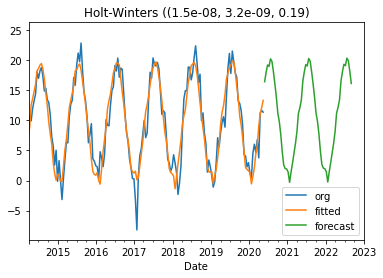

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.765868797210605
       x: [ 1.490e-08  3.154e-09 ... -2.321e-01 -2.489e-01]
     nit: 21
     jac: [ 1.389e+00  0.000e+00 ...  1.097e-05  1.805e-04]
    nfev: 691
    njev: 21
---
{'smoothing_level': 1.4901161193847656e-08, 'smoothing_trend': 3.15414320728823e-09, 'smoothing_seasonal': 0.18517896192880234, 'damping_trend': nan, 'initial_level': 0.5103444997673973, 'initial_trend': 6.71231093713457e-05, 'initial_seasons': array([-0.27315881, -0.31681737, -0.30973867, -0.27963124, -0.19937067,
       -0.19520135, -0.15357677, -0.09712203, -0.05743821,  0.06632433,
        0.12962989,  0.15785139,  0.2156465 ,  0.23558913,  0.27185061,
        0.28384558,  0.30953899,  0.29416054,  0.20638752,  0.14485354,
        0.1060076 ,  0.05625821, -0.03352123, -0.09595913, -0.23207126,
       -0.24889348]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
---
                     name         param  opti

Dep. Variable:,scal,No. Observations:,663
Model:,ExponentialSmoothing,SSE,3.766
Optimized:,True,AIC,-3368.238
Trend:,Additive,BIC,-3233.335
Seasonal:,Additive,AICC,-3364.886
Seasonal Periods:,26,Date:,"Tue, 06 Feb 2024"
Box-Cox:,False,Time:,13:30:34
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.4901e-08,alpha,True
smoothing_trend,3.1541e-09,beta,True


In [16]:
fig, ax = plt.subplots()
dh['AvgTemperature'].plot(ax=ax)
dh['fitted'].plot(ax=ax)
dhfc['forecast'].plot(ax=ax)
ax.legend(['org', 'fitted', 'forecast'])
ax.set_xlim('2014-04-01','2022-12-30')
plt.title('Holt-Winters ('+ hw_param )
plt.show()

print(dmodel.mle_retvals)
print('-'*3)
print(dmodel.params)
print('-'*3)
print(dmodel.params_formatted)
dmodel.summary()

## 3. Milchproduktion

Quellen:

Quellen: Milk availability, usage and production dataset: https://www.gov.uk/government/statistics/milk-utilisation-by-dairies-in-england-and-wales

Datendatei: https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1121068/milkutil-dataset-01dec22.ods]


### Laden der Daten

In [17]:
%reset -f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

url = 'https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1121068/milkutil-dataset-01dec22.ods'


In [18]:
# pd.read_excel(url, engine="odf")

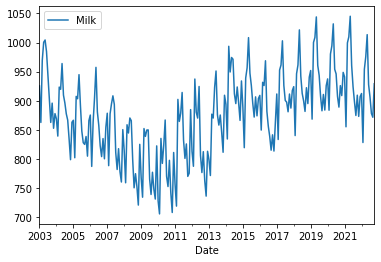

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 238 entries, 2003-01-31 to 2022-10-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Milk    238 non-null    float64
dtypes: float64(1)
memory usage: 3.7 KB


In [19]:
fn = 'data/milkutil-dataset-01dec22.csv'
#fn = 'data/t1.csv'

# skip 8 lines
# superscript numbers in column 2
# engine='python': required for: skipfooter=10
# rename header: names = ['Date', 'Milk'], header = 0,

df = pd.read_csv(fn, usecols=[0,5], parse_dates=['Date'], index_col='Date', 
        names = ['Date', 'Milk'], header = 0,
        skiprows=8, encoding = "ISO-8859-1", engine='python', skipfooter=9)

df = df.resample('M').mean()

df.plot()
plt.show()

df.info()

### Datenfit und -vorhersage

In [20]:
# in case of convergence error
# method 1: scale input values

from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

dh = df.copy()

sc = MinMaxScaler(feature_range = (0.00001,1))
dh['scal'] = sc.fit_transform(dh)

model = ExponentialSmoothing(dh['scal'], trend='add',  seasonal='add', use_boxcox=True,
                           seasonal_periods=12)

dmodel = model.fit()

dh['fitted'] = sc.inverse_transform([dmodel.fittedvalues.tolist()])[0,:]
dhfc = pd.DataFrame(dmodel.forecast(36))
dhfc['forecast'] = sc.inverse_transform([dhfc.iloc[:,0].tolist()])[0,:]

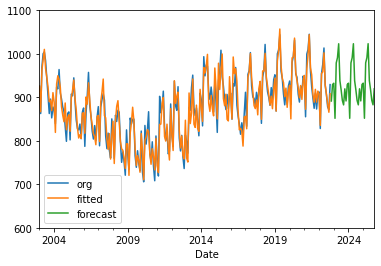

Dep. Variable:,scal,No. Observations:,238
Model:,ExponentialSmoothing,SSE,0.980
Optimized:,True,AIC,-1275.276
Trend:,Additive,BIC,-1219.720
Seasonal:,Additive,AICC,-1272.153
Seasonal Periods:,12,Date:,"Tue, 06 Feb 2024"
Box-Cox:,True,Time:,13:30:35
Box-Cox Coeff.:,0.91471,,
,coeff,code,optimized
smoothing_level,0.5363082,alpha,True
smoothing_trend,1.7836e-15,beta,True


In [21]:
fig, ax = plt.subplots()
dh['Milk'].plot(ax=ax)

dh['fitted'].plot(ax=ax)
dhfc['forecast'].plot(ax=ax)

ax.legend(['org', 'fitted', 'forecast'])
ax.set_ylim(600,1100)
plt.show()

dmodel.summary()

In [22]:
# method 2: use "least square": model.fit(method = 'ls')

dh = df.copy()

#sc = MinMaxScaler(feature_range = (0.00001,1))
#dh['scal'] = sc.fit_transform(dh)

model = ExponentialSmoothing(dh['Milk'], trend='add',  seasonal='add', use_boxcox=True,
                           seasonal_periods=12)

dmodel = model.fit(method = 'ls')

#dh['fitted'] = sc.inverse_transform([dmodel.fittedvalues.tolist()])[0,:]
dh['fitted'] = dmodel.fittedvalues.tolist()
dhfc = pd.DataFrame(dmodel.forecast(36))
#dhfc['forecast'] = dhfc.iloc[:,0].tolist()])[0,:]
dhfc.columns = ['forecast']

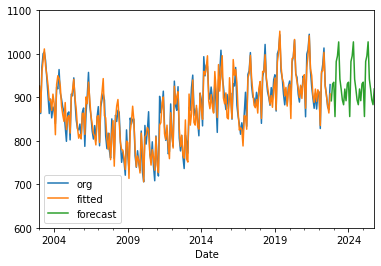

Dep. Variable:,Milk,No. Observations:,238
Model:,ExponentialSmoothing,SSE,108863.773
Optimized:,True,AIC,1489.888
Trend:,Additive,BIC,1545.445
Seasonal:,Additive,AICC,1493.012
Seasonal Periods:,12,Date:,"Tue, 06 Feb 2024"
Box-Cox:,True,Time:,13:30:35
Box-Cox Coeff.:,1.55784,,
,coeff,code,optimized
smoothing_level,0.5228081,alpha,True
smoothing_trend,1.2315e-27,beta,True


In [23]:
fig, ax = plt.subplots()
dh['Milk'].plot(ax=ax)

dh['fitted'].plot(ax=ax)
dhfc['forecast'].plot(ax=ax)

ax.legend(['org', 'fitted', 'forecast'])
ax.set_ylim(600,1100)
plt.show()

dmodel.summary()

### Vorhersage zu anderen Zeitpunkten

In [24]:
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

dh = df.copy()
dh = dh.loc[:'2011-12',:] 

sc = MinMaxScaler(feature_range = (0.00001,1))
dh['scal'] = sc.fit_transform(dh)

model = ExponentialSmoothing(dh['scal'], trend='add',  seasonal='add', use_boxcox=True,
                           seasonal_periods=12)

dmodel = model.fit()

dh['fitted'] = sc.inverse_transform([dmodel.fittedvalues.tolist()])[0,:]
dhfc = pd.DataFrame(dmodel.forecast(36))
dhfc['forecast'] = sc.inverse_transform([dhfc.iloc[:,0].tolist()])[0,:]

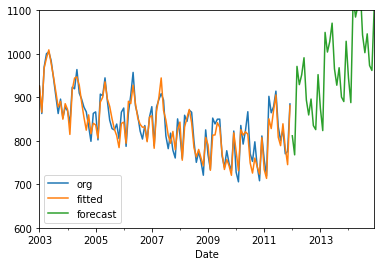

Dep. Variable:,scal,No. Observations:,108
Model:,ExponentialSmoothing,SSE,0.519
Optimized:,True,AIC,-544.536
Trend:,Additive,BIC,-501.622
Seasonal:,Additive,AICC,-536.851
Seasonal Periods:,12,Date:,"Tue, 06 Feb 2024"
Box-Cox:,True,Time:,13:30:36
Box-Cox Coeff.:,0.72735,,
,coeff,code,optimized
smoothing_level,0.1600281,alpha,True
smoothing_trend,0.1600281,beta,True


In [25]:
fig, ax = plt.subplots()
dh['Milk'].plot(ax=ax)

dh['fitted'].plot(ax=ax)
dhfc['forecast'].plot(ax=ax)

ax.legend(['org', 'fitted', 'forecast'])
ax.set_ylim(600,1100)
plt.show()

dmodel.summary()